# Аналитика в Яндекс.Афише

1. [Шаг 1. Подготовка данных к анализу ](#step1)
2. [Шаг 2. Отчеты и метрики](#step2) 
    1. [Продукт](#product)
    2. [Продажи](#sales)
    3. [Маркетинг](#marketing)
3. [Шаг 3. Выводы и рекомендации](#step3)


## Шаг 1 Подготовка данных к анализу <a name="step1"></a>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
pd.plotting.register_matplotlib_converters()

visits_log = pd.read_csv('/datasets/visits_log.csv')
visits_log.name = 'visits_log'
orders_log = pd.read_csv('/datasets/orders_log.csv')
orders_log.name = 'orders_log'
costs = pd.read_csv('/datasets/costs.csv')
costs.name = 'costs'

In [2]:
#функция для просмотра информации о таблице
def show_info(df):
    display(df.name)
    display(df.head())
    display(df.info())
    print('Количество дубликатов ', df.duplicated().sum())

In [3]:
for df in [visits_log, orders_log, costs]:
    show_info(df)

'visits_log'

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

Количество дубликатов  0


'orders_log'

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

Количество дубликатов  0


'costs'

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

Количество дубликатов  0


Пропущенных значений нет, но необходимо перевести столбцы с датой-временем в соотетствующий тип и изменить названия столбцов

In [4]:
#заменим названия столбцов: приведем в нижний регистр и заменим пробел на нижнее подчеркивание
for df in [visits_log, orders_log, costs]:
    df.columns = df.columns.str.lower().str.replace(' ', '_')

In [5]:
#замена типа данных на дату-время
visits_log['start_ts'] = pd.to_datetime(visits_log['start_ts'], format = '%Y-%m-%d %H:%M:%S')
visits_log['end_ts'] = pd.to_datetime(visits_log['end_ts'], format = '%Y-%m-%d %H:%M:%S')
orders_log['buy_ts'] = pd.to_datetime(orders_log['buy_ts'], format = '%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format = '%Y-%m-%d')

In [6]:
for df in [visits_log, orders_log, costs]:
    display(df.name)
    df.info()

'visits_log'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


'orders_log'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


'costs'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### Вывод
Формат названий столбцов изменен для удобства дальнейшей работы, в столбцах, содержащих дату и время, тип данных изменен на соответствующий

## Шаг 2. Отчеты и метрики <a name="step2"></a>

### Продукт <a name="product"></a>

***Сколько людей пользуются в день, неделю, месяц?***

In [7]:
#выделим из даты год, месяц и день
visits_log['start_ts_year'] = visits_log['start_ts'].dt.year
visits_log['start_ts_month'] = visits_log['start_ts'].astype('datetime64[M]')
visits_log['start_ts_day'] = visits_log['start_ts'].astype('datetime64[D]')

#посчитаем день начала недели, в которую произошло событие для идентификации недели
visits_log['start_ts_week'] =\
    pd.to_datetime(visits_log['start_ts'], unit='d') - \
    pd.to_timedelta(visits_log['start_ts'].dt.dayofweek, unit='d')
visits_log['start_ts_week'] = visits_log['start_ts_week'].astype('datetime64[D]')

visits_log.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_day,start_ts_week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,2017-12-20,2017-12-18
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,2018-02-19,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,2017-07-01,2017-06-26
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,2018-05-20,2018-05-14
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,2017-12-27,2017-12-25


Рассмотрим, как менялось количество посетителей со временем:

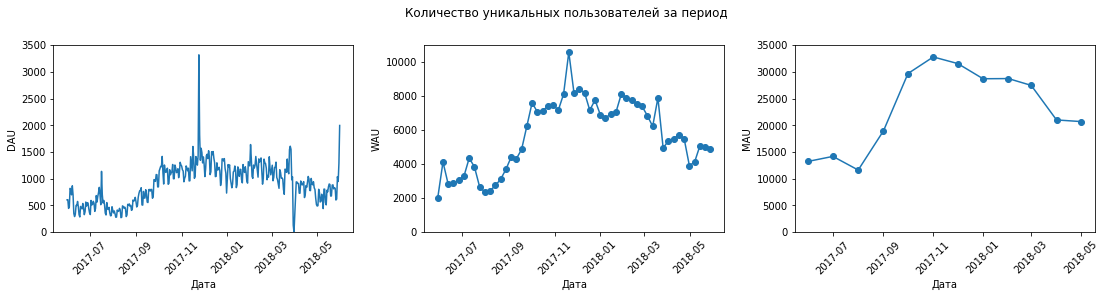

In [8]:

fig, ax = plt.subplots(1,3, figsize = (16,4))
fig.tight_layout(pad=4.0)
plt.suptitle('Количество уникальных пользователей за период')
plt.rcParams['axes.grid'] = True

ax[0].plot(visits_log.groupby('start_ts_day')['uid'].nunique())
ax[0].set_xlabel('Дата')
ax[0].set_ylabel('DAU')
plt.setp(ax[0].get_xticklabels(), rotation=45)
ax[0].set_ylim(bottom=0, top = 3500)

ax[1].plot(visits_log.groupby(['start_ts_week'])['uid'].nunique(), marker = 'o')
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('WAU')
ax[1].set_ylim(bottom=0, top = 11000)
plt.setp(ax[1].get_xticklabels(), rotation=45)

ax[2].plot(visits_log.groupby(['start_ts_month'])['uid'].nunique(), marker = 'o')
ax[2].set_xlabel('Дата')
ax[2].set_ylabel('MAU')
ax[2].set_ylim(bottom=0, top = 35000)
plt.setp(ax[2].get_xticklabels(), rotation=45)
plt.show()


In [9]:
#Определим, в какой день был всплеск активности
dau_daily = visits_log.groupby('start_ts_day').agg({'uid':'nunique'})
dau_daily[dau_daily['uid'] == dau_daily['uid'].max()]

,uid
start_ts_day,
2017-11-24,3319


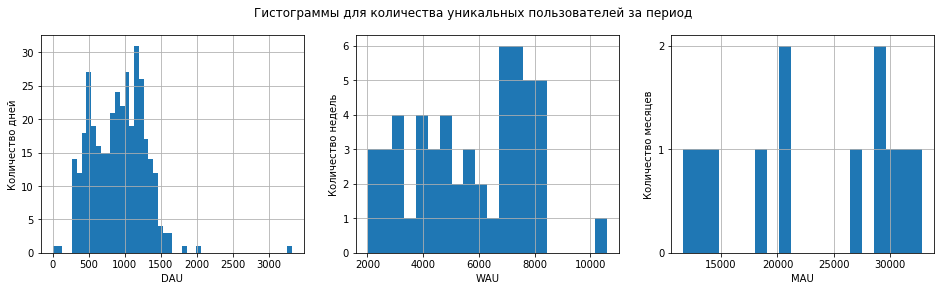

In [10]:
fig, ax = plt.subplots(1,3, figsize = (16,4))


ax[0].hist(visits_log.groupby('start_ts_day')['uid'].nunique(), bins=50)
ax[0].set_xlabel('DAU')
ax[0].set_ylabel('Количество дней')

ax[1].hist(visits_log.groupby(['start_ts_week'])['uid'].nunique(), bins=20)
ax[1].set_xlabel('WAU')
ax[1].set_ylabel('Количество недель')

ax[2].hist(visits_log.groupby(['start_ts_month'])['uid'].nunique(), bins=20)
ax[2].set_xlabel('MAU')
ax[2].set_ylabel('Количество месяцев')
ax[2].yaxis.set_major_locator(plt.MultipleLocator(1))

plt.rcParams['axes.grid'] = True
plt.suptitle('Гистограммы для количества уникальных пользователей за период')

plt.show()

Распределения количества посетителей симметричные, поэтому средние значения будут характеризовать центр распределения.

In [11]:
mau = int(visits_log.\
          groupby('start_ts_month').\
          agg({'uid':'nunique'}).\
          mean())
wau = int(visits_log.\
          groupby(['start_ts_week']).\
          agg({'uid':'nunique'}).\
          mean())
dau = int(visits_log.\
          groupby('start_ts_day').\
          agg({'uid':'nunique'}).\
          mean())

print('Среднее количество уникальных пользователей в день (DAU) =', dau)
print('Среднее количество уникальных пользователей в неделю (WAU) =', wau)
print('Среднее количество уникальных пользователей в месяц (MAU) =', mau)

Среднее количество уникальных пользователей в день (DAU) = 907
Среднее количество уникальных пользователей в неделю (WAU) = 5716
Среднее количество уникальных пользователей в месяц (MAU) = 23228


Среднее количество уникальных пользователей в день (DAU) touch = 252
Среднее количество уникальных пользователей в неделю (WAU) touch = 1634
Среднее количество уникальных пользователей в месяц (MAU)  touch = 6825

Среднее количество уникальных пользователей в день (DAU) desktop = 659
Среднее количество уникальных пользователей в неделю (WAU) desktop = 4129
Среднее количество уникальных пользователей в месяц (MAU)  desktop = 16724



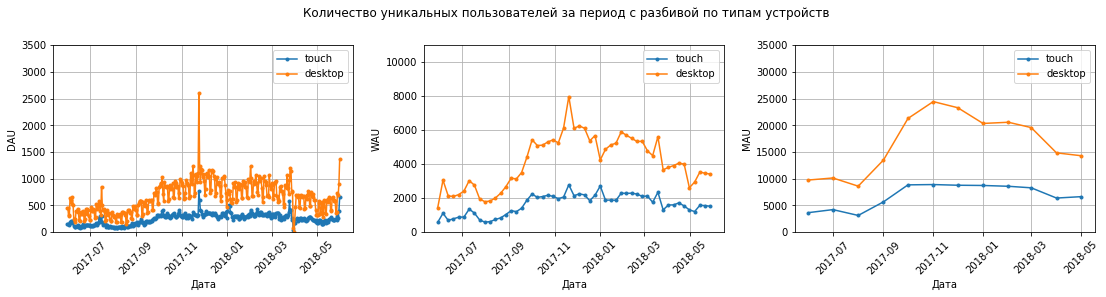

In [12]:
# С разбивкой по типам устройств
fig, ax = plt.subplots(1,3, figsize = (16,4))
fig.tight_layout(pad=4.0)
plt.suptitle('Количество уникальных пользователей за период с разбивой по типам устройств')
plt.rcParams['axes.grid'] = True

for device in visits_log['device'].unique():
    mau = int(visits_log.\
          query('device == @device').\
          groupby('start_ts_month').\
          agg({'uid':'nunique'}).\
          mean())
    
    wau = int(visits_log.\
          query('device == @device').\
          groupby(['start_ts_week']).\
          agg({'uid':'nunique'}).\
          mean())
    
    dau = int(visits_log.\
         query('device == @device').\
          groupby('start_ts_day').\
          agg({'uid':'nunique'}).\
          mean())
    
    print('Среднее количество уникальных пользователей в день (DAU) ' + str(device) + ' =', dau)
    print('Среднее количество уникальных пользователей в неделю (WAU) '+ str(device) + ' =', wau)
    print('Среднее количество уникальных пользователей в месяц (MAU)  '+ str(device) + ' =', mau)
    print()
    
for device in visits_log['device'].unique():    
    ax[0].plot(visits_log.\
                   query('device == @device').\
                   groupby('start_ts_day')['uid'].\
                   nunique(), 
                           label = str(device),
                           marker = 'o',
                           markersize = 3)
    ax[0].set_xlabel('Дата')
    ax[0].set_ylabel('DAU')
    plt.setp(ax[0].get_xticklabels(), rotation=45)
    ax[0].set_ylim(bottom=0, top = 3500)
    ax[0].legend()
    
    ax[1].plot(visits_log.\
                   query('device == @device').\
                   groupby(['start_ts_week'])['uid'].\
                   nunique(), 
                           marker = 'o', 
                           label = str(device),
                           markersize = 3)
    ax[1].set_xlabel('Дата')
    ax[1].set_ylabel('WAU')
    ax[1].set_ylim(bottom=0, top = 11000)
    plt.setp(ax[1].get_xticklabels(), rotation=45)
    ax[1].legend()
    
    ax[2].plot(visits_log.\
                   query('device == @device').\
                   groupby(['start_ts_month'])['uid'].\
                   nunique(), 
                       marker = 'o',
                       label = str(device),
                       markersize = 3)
    ax[2].set_xlabel('Дата')
    ax[2].set_ylabel('MAU')
    ax[2].set_ylim(bottom=0, top = 35000)
    plt.setp(ax[2].get_xticklabels(), rotation=45)
    ax[2].legend()
plt.show()

#### Вывод
Среднее количество уникальных пользователей в день (DAU) = 907

Среднее количество уникальных пользователей в неделю (WAU) = 5716

Среднее количество уникальных пользователей в месяц (MAU) = 23228

Количество уникальных пользователей растет начиная с августа 2017 года. Выделяется резкий пик популярности использования сервиса в конце ноября 2017 года, что скорее всего связано с покупкой билетов на новогодние мероприятия. В марте 2018 года количество уникальных пользователей начинает уменьшаться. Это можно объяснить сезонным снижением спроса на культурные мероприятия летом

Количество уникальных пользователей, заходящих с компьютеров примерно втрое выше, чем со смартфонов и планшетов, в остальном динамика метрик совпадает

***Сколько сессий в день?***

In [13]:
n_sessions = visits_log.\
                            groupby('start_ts_day').\
                            agg(n_sessions = pd.NamedAgg(column = 'start_ts', aggfunc = 'count'))
print('Среднее количество сессий в день',int(n_sessions.mean()) )

Среднее количество сессий в день 987


In [14]:
#Среднее количество пользователей по дням:
n_users = visits_log.\
                groupby(['start_ts_day']).\
                agg(n_users = pd.NamedAgg(column = 'uid', aggfunc = 'nunique'))

n_sessions_per_user = n_users.\
                        merge(n_sessions, on = 'start_ts_day').\
                        assign(n_sessions_per_user = lambda x: x['n_sessions'] / x['n_users'])

print('Cреднее количество сессий одного пользователя в день {:.2f}'.\
                              format(n_sessions_per_user['n_sessions_per_user'].mean()))

Cреднее количество сессий одного пользователя в день 1.08


#### Вывод
Большинство пользователей совершают одну сессию в день

***Сколько длится одна сессия?***

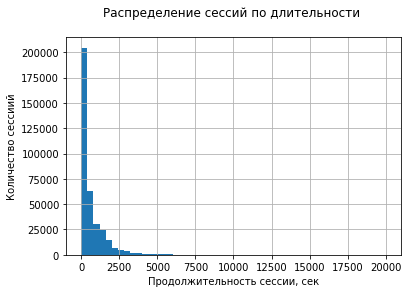

In [15]:
visits_log['session_duration'] = (visits_log['end_ts'] - visits_log['start_ts']).dt.seconds
visits_log['session_duration'].hist(bins=50, range = (0,20000))
plt.xlabel('Продолжительность сессии, сек')
plt.ylabel('Количество сессиий')
plt.title('Распределение сессий по длительности \n')
plt.show()

In [16]:
#Распределение не нормальное, для определения наиболее частого значения используем моду
asl = int(visits_log['session_duration'].mode())
print('Наиболее типичная продолжительность сессии (ASL) = {:.0f} сек'.format(asl))

Наиболее типичная продолжительность сессии (ASL) = 60 сек


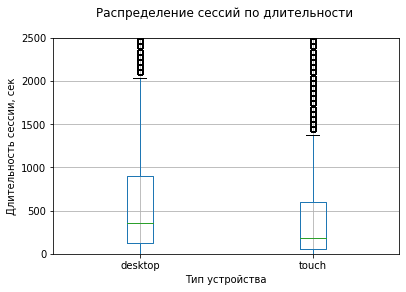

In [17]:
visits_log.boxplot(column = 'session_duration',by='device')
plt.ylabel('Длительность сессии, сек')
plt.suptitle('')
plt.xlabel('Тип устройства')
plt.title('Распределение сессий по длительности \n')
plt.ylim(0,2500)
plt.show()


In [18]:
visits_log.groupby('device')['session_duration'].agg([pd.Series.mode, 'median'])

,mode,median
device,,
desktop,60,360
touch,60,180


#### Вывод
Наиболее типичная продолжительность сессии (ASL) 60 сек на всех типах устройств. Скорее всего это автоматическое завершение сессии через фиксированный промежуток при отсутсвии активности пользователя. Однако сессии с компьютеров в среднем в два раза длиннее

***Как часто люди возвращаются?***

Разделим пользователей на когорты и проверим, какой процент из них далее возвращается к использованию сервиса (Retention Rate). Большинство людей не посещают культурные мероприятия каждый день или каждую неделю, поэтому выберем интервал 1 месяц для изучения характерных изменений. Разделим пользователей по месяцу, когда они впервые воспользовались сервисом.

In [19]:
#месяц первой сессии каждого пользователя
first_activity_month = visits_log.groupby('uid')['start_ts'].min().astype('datetime64[M]')
first_activity_month.name = 'first_activity_month'

visits_log = visits_log.join(first_activity_month, on = 'uid')

visits_log['lifetime'] = (visits_log['start_ts_month'] - 
                          visits_log['first_activity_month']) / np.timedelta64(1,'M')
visits_log['lifetime'] = visits_log['lifetime'].\
                                round().\
                                astype('int')  
visits_log.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_day,start_ts_week,session_duration,first_activity_month,lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,2017-12-20,2017-12-18,1080,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,2018-02-19,2018-02-19,1680,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,2017-07-01,2017-06-26,0,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,2018-05-20,2018-05-14,1440,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,2017-12-27,2017-12-25,0,2017-12-01,0


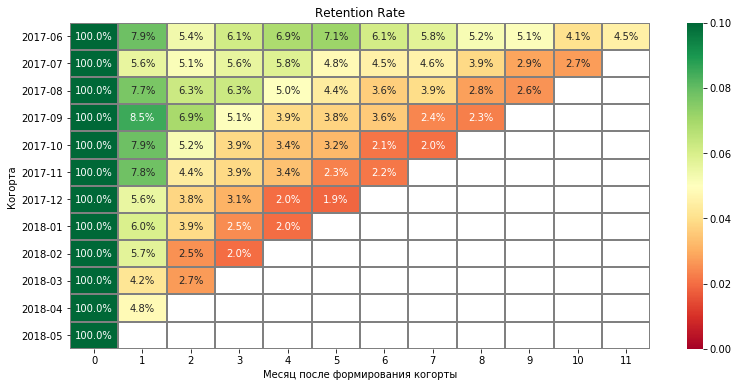

In [20]:
#разделим пользователей на когорты с интервалом в месяц
cohorts = visits_log.\
    groupby(['first_activity_month', 'lifetime']).\
    agg({'uid':'nunique'}).\
    reset_index()
cohorts = cohorts.rename(columns={'uid':'n_users'})

#начальное число пользователей для каждой когорты
initial_users_count = cohorts[cohorts['lifetime'] == 0].\
                        filter(['first_activity_month','n_users' ]).\
                        reset_index(drop=True)
initial_users_count = initial_users_count.rename(columns={'n_users':'cohort_size'})
initial_users_count.name = 'initial_users_count'


#отношениe текущего количества пользователей к исходному
cohorts = cohorts.merge(initial_users_count, on = 'first_activity_month')
cohorts['retention'] = cohorts['n_users'] / cohorts['cohort_size']

cohorts_pivot = cohorts.\
                    pivot_table(
                        index = 'first_activity_month',
                        columns = 'lifetime',
                        values = 'retention')
#построим тепловую карту

plt.figure(figsize=(13, 6))
plt.title('Retention Rate')
ax = sns.heatmap(cohorts_pivot, 
            annot=True, 
            fmt='.1%', 
            linewidths=1, 
            linecolor='gray', 
            vmax = 0.1,
            vmin = 0,
            cmap="RdYlGn",
            yticklabels = cohorts_pivot.index.strftime('%Y-%m')
                )
plt.ylabel('Когорта')
plt.xlabel('Месяц после формирования когорты')
plt.show()

In [21]:
#усредненные значения
cohorts_pivot.mean(axis=0).loc[[0,1,5]]

lifetime
0    1.000000
1    0.065167
5    0.039444
dtype: float64

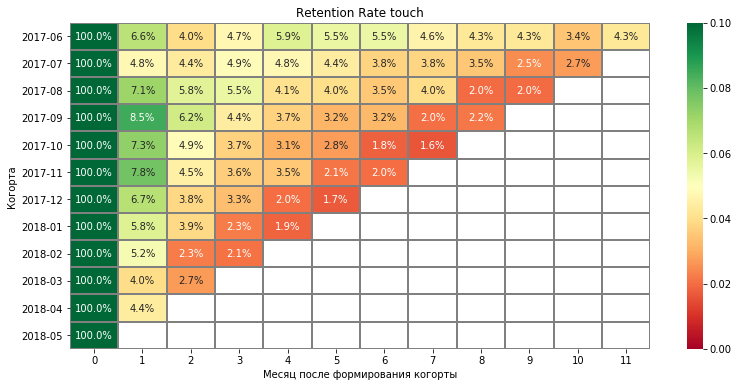

Средниее значение за 6 месяцев 3.4%


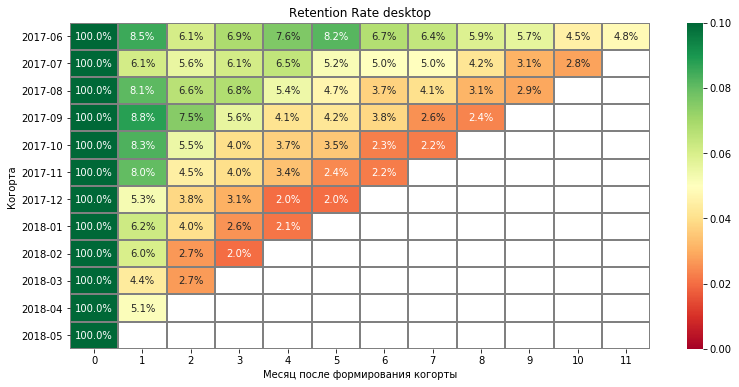

Средниее значение за 6 месяцев 4.3%


In [22]:
# Отдельно для разных видов устройств
for device in visits_log['device'].unique():

#разделим пользователей на когорты с интервалом в месяц
    cohorts = visits_log.\
        query('device == @device').\
        groupby(['first_activity_month', 'lifetime']).\
        agg({'uid':'nunique'}).\
        reset_index()
    cohorts = cohorts.rename(columns={'uid':'n_users'})

#начальное число пользователей для каждой когорты
    initial_users_count = cohorts[cohorts['lifetime'] == 0].\
                        filter(['first_activity_month','n_users' ]).\
                        reset_index(drop=True)
    initial_users_count = initial_users_count.rename(columns={'n_users':'cohort_size'})
    initial_users_count.name = 'initial_users_count'


#отношениe текущего количества пользователей к исходному
    cohorts = cohorts.merge(initial_users_count, on = 'first_activity_month')
    cohorts['retention'] = cohorts['n_users'] / cohorts['cohort_size']
    
    cohorts_pivot = cohorts.\
                    pivot_table(
                        index = 'first_activity_month',
                        columns = 'lifetime',
                        values = 'retention')
#построим тепловую карту

    plt.figure(figsize=(13, 6))
    plt.title('Retention Rate '+str(device))
    ax = sns.heatmap(cohorts_pivot, 
            annot=True, 
            fmt='.1%', 
            linewidths=1, 
            linecolor='gray', 
            vmax = 0.1,
            vmin = 0,
            cmap="RdYlGn",
            yticklabels = cohorts_pivot.index.strftime('%Y-%m')
                )
    plt.ylabel('Когорта')
    plt.xlabel('Месяц после формирования когорты')
    plt.show()
    print('Средниее значение за 6 месяцев {:.1%}'.format(cohorts_pivot.loc[:,5].mean()))

#### Вывод
Доля клиентов, возвращающихся к использованию сервиса на второй месяц после первого визита в среднем составляет 6.5% и резко упала после декабря 2017 года. Через 6 месяцев в среднем остается 4% посетителей. В каждой следующей когорте скорость оттока посетителей возрастает. Минимальный процент для первой когорты (4.5%) наблюдался через год после регистрации клиента, для когорты пользователей, зарегистрированных в марте 2018 года это значение наблюдалось уже через месяц.

Пользователи чаще возвращаются, если заходят с комьютера (4.3% в среднем за 6 месяцев), чем со смартформа или планшета (3.4% в среднем за 6 месяцев). Возможно пользоватся сервисом в мобильной версии менее удобно

### Продажи <a name="sales"></a>

***Когда люди начинают покупать?***

In [23]:
#определим время первой сессии и первой покупки для каждого пользователя
first_activity_time = visits_log.\
                groupby('uid')['start_ts'].\
                min()
first_order_time = orders_log.\
                    groupby('uid')['buy_ts'].\
                    min()

#вычислим интервал между первой сессией и первой покупкой в днях
session_order = pd.concat([first_activity_time, first_order_time], axis=1, join='inner')
session_order['delta_days'] = pd.to_timedelta(session_order['buy_ts'] - session_order['start_ts'], 
                                                                  unit = 'd') / np.timedelta64(1,'D')
session_order.head()

,start_ts,buy_ts,delta_days
uid,,,
313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106.959722
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.000000
2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0.054861
2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0.822222
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.000000


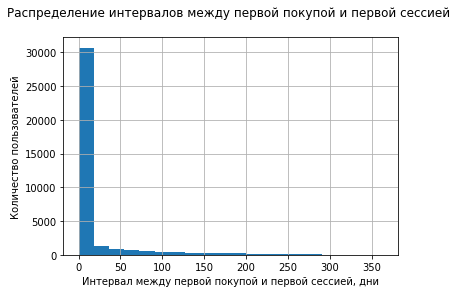

In [24]:
session_order['delta_days'].hist(bins = 20)
plt.ylabel('Количество пользователей')
plt.xlabel('Интервал между первой покупой и первой сессией, дни')
plt.title('Распределение интервалов между первой покупой и первой сессией \n')
plt.show()

In [25]:
print('Наиболее типичный интервал между первой сессией и покупкой {:.0f} дней'.\
                                      format(int(session_order['delta_days'].mode())))

Наиболее типичный интервал между первой сессией и покупкой 0 дней


In [26]:
# Отдельно для разных видов устройств
for device in visits_log['device'].unique():
    #определим время первой сессии и первой покупки для каждого пользователя
    first_activity_time = visits_log.\
                groupby('uid')['start_ts'].\
                min()
    first_order_time = orders_log.\
                    groupby('uid')['buy_ts'].\
                    min()

#вычислим интервал между первой сессией и первой покупкой в днях
    session_order = pd.concat([first_activity_time, first_order_time], axis=1, join='inner')
    session_order['delta_days'] = pd.to_timedelta(session_order['buy_ts'] - session_order['start_ts'], 
                                                                  unit = 'd') / np.timedelta64(1,'D')
    print(('Наиболее типичный интервал между первой сессией и покупкой {:.0f} дней для типа устройства ' + str(device)).\
                                      format(int(session_order['delta_days'].mode())))

Наиболее типичный интервал между первой сессией и покупкой 0 дней для типа устройства touch
Наиболее типичный интервал между первой сессией и покупкой 0 дней для типа устройства desktop


#### Вывод
Большинство пользователей совершает покупку в первый день пользования сервисом независимо от типа устройства

***Сколько раз покупают за период?***

In [27]:
#выделим месяц каждого заказа
orders_log['order_month'] = orders_log['buy_ts'].astype('datetime64[M]')

#определим месяц первого заказа для каждого покупателя
first_order_month = orders_log.groupby('uid')['order_month'].min()
first_order_month.name = 'first_order_month'
first_order_month

#объединим данные
orders_log = orders_log.\
                merge(first_order_month, on = 'uid')
orders_log.head()

,buy_ts,revenue,uid,order_month,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [28]:
#Общее количество покупателей в каждой из рассматриваемых когорт
buyers_cohorts = orders_log.\
                        groupby('first_order_month').\
                        agg(n_buyers = pd.NamedAgg(column = 'uid', aggfunc = 'nunique'))


#рассчитаем возраст когорты для каждого заказа
orders_log['cohort_age'] = (orders_log['order_month'] -\
                         orders_log['first_order_month']) / np.timedelta64(1, 'M')
orders_log['cohort_age'] = orders_log['cohort_age'].round().astype('int')
orders_log.head()

orders_log = orders_log.\
                merge(buyers_cohorts, on = 'first_order_month')
orders_log.head()

,buy_ts,revenue,uid,order_month,first_order_month,cohort_age,n_buyers
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,0,2023
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,0,2023
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,0,2023
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,0,2023
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,0,2023


In [29]:
# среднее количество заказов для каждого покупателя в месяц
orders_summary = orders_log.\
                    groupby(['first_order_month', 'cohort_age']).\
                    agg(n_orders = pd.NamedAgg(column = 'buy_ts', aggfunc = 'count')).\
                    reset_index().\
                    merge(buyers_cohorts, on = 'first_order_month').\
                    assign(orders_avg = lambda x: x['n_orders'] / x['n_buyers'])
                    
orders_summary.head()

,first_order_month,cohort_age,n_orders,n_buyers,orders_avg
0,2017-06-01,0,2354,2023,1.163618
1,2017-06-01,1,177,2023,0.087494
2,2017-06-01,2,174,2023,0.086011
3,2017-06-01,3,226,2023,0.111715
4,2017-06-01,4,292,2023,0.144340


In [30]:
#сводная таблица по когортам
orders_per_buyer = orders_summary.\
                        pivot_table(
                            index = 'first_order_month',
                            columns = 'cohort_age',
                            values = 'orders_avg').\
                        cumsum(axis=1)
display(orders_per_buyer)

cohort_age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.163618,1.251112,1.337123,1.448838,1.593178,1.700939,1.837370,1.923381,2.028176,2.103806,2.151261,2.193772
2017-07-01,1.136765,1.188768,1.251170,1.305252,1.342694,1.385335,1.417057,1.443058,1.473219,1.485699,1.513261,NaN
2017-08-01,1.118978,1.197810,1.270803,1.329927,1.391971,1.437226,1.472993,1.529927,1.563504,1.597080,NaN,NaN
2017-09-01,1.136381,1.221232,1.283611,1.347152,1.373111,1.415343,1.457187,1.478884,1.502518,NaN,NaN,NaN
2017-10-01,1.143779,1.216129,1.253456,1.281567,1.311290,1.335023,1.354839,1.383641,NaN,NaN,NaN,NaN
2017-11-01,1.179368,1.276648,1.321245,1.372948,1.406273,1.420730,1.445724,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.152635,1.214237,1.260324,1.301164,1.320785,1.344741,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.121554,1.187963,1.235102,1.254076,1.277201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.121611,1.182416,1.205149,1.224322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 33.0, 'Месяц после формирования когорты')

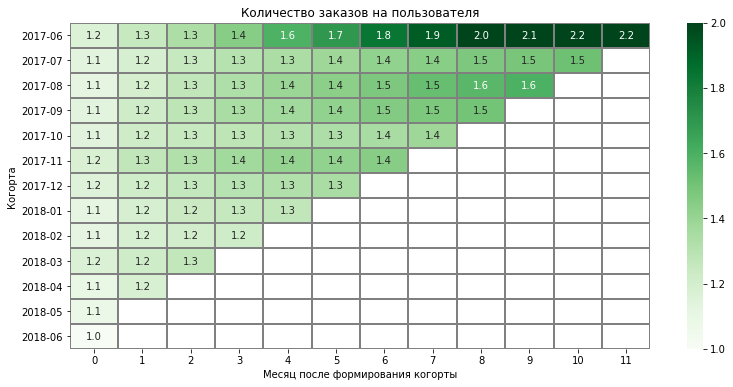

In [31]:
plt.figure(figsize=(13, 6))
plt.title('Количество заказов на пользователя')
ax = sns.heatmap(orders_per_buyer, 
            annot=True, 
            fmt='.1f', 
            linewidths=1, 
            vmax = 2,
            linecolor='gray',
            cmap="Greens",
            yticklabels = orders_per_buyer.index.strftime('%Y-%m')
                )
plt.ylabel('Когорта')
plt.xlabel('Месяц после формирования когорты')

Для накопительных итогов график нагляднее тепловой карты

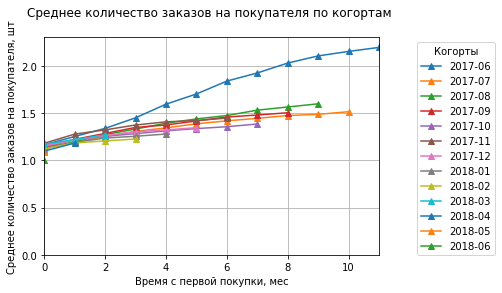

In [32]:
labels = orders_per_buyer.index.strftime('%Y-%m')
orders_per_buyer.T.plot(marker = '^')
plt.legend(bbox_to_anchor=(1.1, 1), title = 'Когорты', labels = labels)
plt.title('Среднее количество заказов на покупателя по когортам \n')
plt.ylabel('Среднее количество заказов на покупателя, шт')
plt.xlabel('Время с первой покупки, мес')
plt.ylim(0,2.3)
plt.show()

Рассчитаем среднее за 6 месяцев жизни: за это время покупатели делают большую часть своих покупок, и есть достаточное количество когорт с этим временим жизни для усреднения

In [33]:
# Сделаем срез по сводной таблице для 6 месяца жизни когорт. Далее посчитаем по нему среднее
orders_per_buyer.loc[:,5]

first_order_month
2017-06-01    1.700939
2017-07-01    1.385335
2017-08-01    1.437226
2017-09-01    1.415343
2017-10-01    1.335023
2017-11-01    1.420730
2017-12-01    1.344741
2018-01-01         NaN
2018-02-01         NaN
2018-03-01         NaN
2018-04-01         NaN
2018-05-01         NaN
2018-06-01         NaN
Name: 5, dtype: float64

Когорта 2017-06 значительно отличается от всех остальных, посмотрим как она влияет на среднее

In [34]:
print('Среднее значение количества заказов на пользователя за 6 месяцев для всех когорт = {:.2f}'.\
                                                              format(orders_per_buyer.loc[:,5].mean()))

print('Среднее значение количества заказов на пользователя за 6 месяцев без когорты 2017-06 = {:.2f}'.\
                                                              format(orders_per_buyer.\
                                                                         query('index != "2017-06-01"').\
                                                                         loc[:,5].\
                                                                         mean()))

Среднее значение количества заказов на пользователя за 6 месяцев для всех когорт = 1.43
Среднее значение количества заказов на пользователя за 6 месяцев без когорты 2017-06 = 1.39


#### Вывод
Среднее количество заказов на одного покупателя за 6 месяцев составляет 1.4

***Какой средний чек?***

Единицы измерения выручки не указаны, но скорее всего это тыс.руб, будем дальше использовать эти идиницы

,revenue,buy_ts,average_cheque
order_day,,,
2017-06-01,389.46,96,4.056875
2017-06-02,324.11,111,2.919910
2017-06-03,166.48,67,2.484776
2017-06-04,195.21,66,2.957727
2017-06-05,441.49,161,2.742174


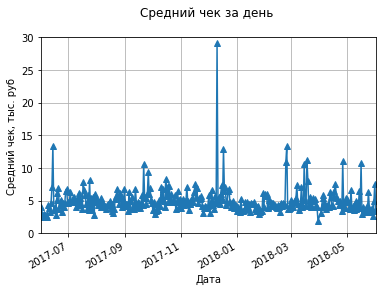

In [35]:
orders_log['order_day'] = orders_log['buy_ts'].astype('datetime64[D]')
avg_cheque = orders_log.\
            groupby(['order_day']).\
            agg({'revenue':'sum', 'buy_ts':'count'}).\
            assign(average_cheque = lambda x: x['revenue'] / x['buy_ts'])
display(avg_cheque.head())

ax.xaxis.grid(True, which='minor')
avg_cheque['average_cheque'].plot(marker = '^')
plt.ylabel('Средний чек, тыс. руб')
plt.xlabel('Дата')
plt.ylim(0,30)
plt.title('Средний чек за день \n')
plt.show()

In [36]:
#Определим, в какой день был всплеск активности
avg_cheque = orders_log.\
            groupby(['order_day']).\
            agg({'revenue':'sum', 'buy_ts':'count'}).\
            assign(average_cheque = lambda x: x['revenue'] / x['buy_ts'])
avg_cheque[avg_cheque['average_cheque'] == avg_cheque['average_cheque'].max()]

,revenue,buy_ts,average_cheque
order_day,,,
2017-12-10,4661.33,160,29.133313


In [37]:
print('Средний чек за весь период {:.2f} тыс.руб'.\
              format(orders_log['revenue'].sum() / orders_log['buy_ts'].count()))

Средний чек за весь период 5.00 тыс.руб


In [38]:
# Рассчитаем средний чек по типам устройств
orders_with_sessions = orders_log.\
                            merge(visits_log, on = 'uid', how = 'left').\
                            query('start_ts <= buy_ts <= end_ts').\
                            reset_index(drop = True)

orders_with_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35927 entries, 0 to 35926
Data columns (total 19 columns):
buy_ts                  35927 non-null datetime64[ns]
revenue                 35927 non-null float64
uid                     35927 non-null uint64
order_month             35927 non-null datetime64[ns]
first_order_month       35927 non-null datetime64[ns]
cohort_age              35927 non-null int64
n_buyers                35927 non-null int64
order_day               35927 non-null datetime64[ns]
device                  35927 non-null object
end_ts                  35927 non-null datetime64[ns]
source_id               35927 non-null int64
start_ts                35927 non-null datetime64[ns]
start_ts_year           35927 non-null int64
start_ts_month          35927 non-null datetime64[ns]
start_ts_day            35927 non-null datetime64[ns]
start_ts_week           35927 non-null datetime64[ns]
session_duration        35927 non-null int64
first_activity_month    35927 non-null da

Количество строк в таблице с заказами уменьшилось примерно на 15 тыс относительно исходной таблицы. То есть для многих заказов нет данных по сессии

In [39]:
display(orders_with_sessions.\
            groupby(['device', 'order_month']).\
            agg(n_users = pd.NamedAgg(column = 'uid', aggfunc = 'count') ,
                revenue_sum = pd.NamedAgg(column = 'revenue', aggfunc = 'sum')).\
            assign(avg_cheque = lambda x: x['revenue_sum'] / x['n_users']).\
            groupby('device').\
            mean()
       )

print('Средний чек за весь период {:.2f} тыс.руб'.\
              format(orders_with_sessions['revenue'].sum() / orders_with_sessions['buy_ts'].count()))

,n_users,revenue_sum,avg_cheque
device,,,
desktop,2302.846154,11063.986154,4.682410
touch,499.166667,1942.842500,3.907121


Средний чек за весь период 4.65 тыс.руб


#### Вывод
Средний чек за весь период составил 5 тыс.руб. Значение в течение рассматриваемого периода оставалось постоянным с выбросами в некоторые дни, которые возможно были датами начала продаж билетов на популярные мероприятия

Средний чек заказа, совершенного с компьютера примерно на 15% выше, чем с мобильных устройств. Также число пользователей, совершающих заказы с комьютера почти в 5 раз больше. Возможно это связано с тем, что с компьютера совершать покупку удобнее, и более дорогие заказы клиенты делают в более удобным способом, чтобы минимизировать возможные ошибки

***Сколько денег приносят? (LTV)***

Для расчета LTV необходимо использовать валовую прибыль, но так как маржинальность не указана, предположим, что она 100%. При поступлении дополнительных данных можно будет дополнить расчет

In [40]:
margin_rate = 1
orders_log['gp'] = orders_log['revenue'] * margin_rate

Разделим пользователей на когорты по месяцу первого заказа

In [41]:
cohorts_orders = orders_log.\
                groupby(['first_order_month','cohort_age']).\
                agg({'gp': 'sum'}).\
                reset_index().\
                merge(buyers_cohorts, on = 'first_order_month').\
                assign(gp_per_buyer = lambda x: x['gp'] / x['n_buyers'])
                
cohorts_orders.head()

,first_order_month,cohort_age,gp,n_buyers,gp_per_buyer
0,2017-06-01,0,9557.49,2023,4.724414
1,2017-06-01,1,981.82,2023,0.485329
2,2017-06-01,2,885.34,2023,0.437637
3,2017-06-01,3,1931.30,2023,0.954671
4,2017-06-01,4,2068.58,2023,1.022531


In [42]:
#Рассчитаем для каждой когорты накопительную среднюю сумму покупок на клиента по месяцам
ltv = cohorts_orders.pivot_table(
                index = 'first_order_month',
                columns = 'cohort_age',
                values = 'gp_per_buyer',)

cumulative_ltv = cohorts_orders.pivot_table(
                index = 'first_order_month',
                columns = 'cohort_age',
                values = 'gp_per_buyer',).\
                cumsum(axis=1)

display(cumulative_ltv)

cohort_age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07-01,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983,7.922803,8.084035,8.231180,8.386854,NaN
2017-08-01,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,NaN,NaN
2017-09-01,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071,13.251220,13.435227,NaN,NaN,NaN
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN
2017-11-01,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,4.430394,4.734675,4.877453,4.940151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,4.435262,4.513777,4.587921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


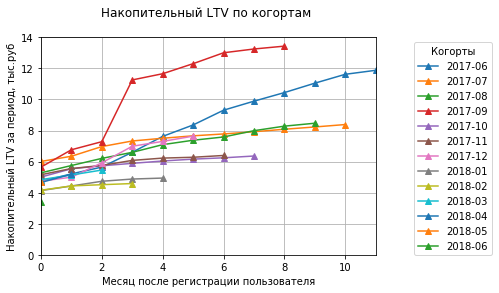

In [43]:
cumulative_ltv.T.plot(marker = '^')
plt.ylim(0,14)
plt.legend(bbox_to_anchor=(1.1, 1), title = 'Когорты', labels=cumulative_ltv.index.strftime('%Y-%m'))
plt.title('Накопительный LTV по когортам \n')
plt.ylabel('Накопительный LTV за период, тыс.руб')
plt.xlabel('Месяц после регистрации пользователя')
plt.show()

Когорта 2017-09 выбивается из общего тренда из-за резкого скачка на четвертый месяц. Далее скорость роста LTV со временем возвращается к среднему для остальных когорт. Из-за этого среднее значение будет завышено

In [44]:
cumulative_ltv_6m = cumulative_ltv.loc[:,5]
cumulative_ltv_6m

first_order_month
2017-06-01     8.360084
2017-07-01     7.660775
2017-08-01     7.375861
2017-09-01    12.306463
2017-10-01     6.159956
2017-11-01     6.280316
2017-12-01     7.639913
2018-01-01          NaN
2018-02-01          NaN
2018-03-01          NaN
2018-04-01          NaN
2018-05-01          NaN
2018-06-01          NaN
Name: 5, dtype: float64

Определим среднее значеение за 6 месяцев для всех когорт, существующих достаточно долго

In [45]:
print('Среднее значение LTV за 6 месяцев для всех когорт {:.2f} тыс.руб'.\
                                                              format(cumulative_ltv_6m.mean()))

Среднее значение LTV за 6 месяцев для всех когорт 7.97 тыс.руб


In [46]:
print('Среднее значение LTV за 6 месяцев для всех когорт, кроме 2017-09 {:.2f} тыс.руб'.\
                          format(cumulative_ltv_6m[cumulative_ltv_6m.index != '2017-09'].mean()))

Среднее значение LTV за 6 месяцев для всех когорт, кроме 2017-09 7.25 тыс.руб


#### Вывод

Среднее значение LTV за 6 месяцев составляет 8 тыс. руб, однако это значение завышено из-за одной когорты, имеющий резкий скачок продаж в декабре 2017 года. В других когортах этого скачка не наблюдается. Без учета этой когорты среднее значение LTV за 6 месяцев составляет 7.25 тыс.руб. Возможно в это время проводились какие-то промо акции

### Маркетинг <a name="marketing"></a>

***Сколько денег потратили? Всего / на каждый источник / по времени***

In [47]:
#месяц, к которому относятся расходы
costs['month'] = costs['dt'].astype('datetime64[M]')

In [48]:
#Суммарные расходы на маркетинг
costs['costs'].sum()

329131.62

In [49]:
#Прибыль
orders_log['revenue'].sum() - costs['costs'].sum()

-77074.41999999998

Расходы превышают доходы

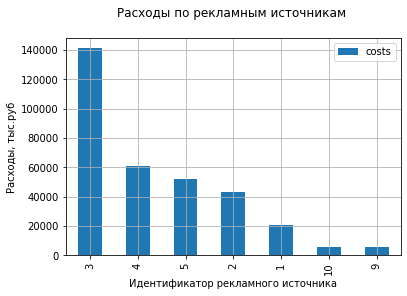

In [50]:
#Распределение расходов по рекламным источникам
costs.\
    groupby('source_id').\
    sum().\
    filter(['costs']).\
    sort_values(by='costs',ascending=False).\
    plot(kind='bar')
plt.ylabel('Расходы, тыс.руб')
plt.xlabel('Идентификатор рекламного источника')
plt.title('Расходы по рекламным источникам \n')
plt.show()


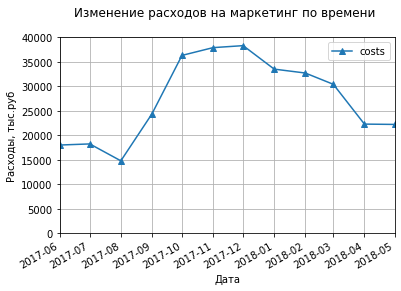

In [51]:
#Распределенеие общих расходов по времени
costs.\
    groupby('month').\
    sum().\
    filter(['costs']).\
    sort_values(by='costs').\
    plot(kind='line', marker = '^')

plt.ylim(0,40000)
plt.ylabel('Расходы, тыс.руб')
plt.xlabel('Дата')
plt.title('Изменение расходов на маркетинг по времени \n')
plt.show()

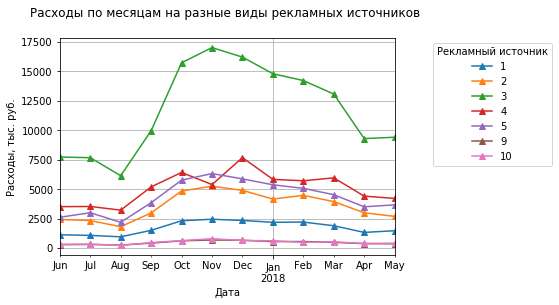

In [52]:
costs.\
    groupby(['month', 'source_id']).\
    sum().\
    unstack().\
    plot(marker = '^')

plt.legend(bbox_to_anchor = (1.1,1), 
           title = 'Рекламный источник', 
           labels = costs['source_id'].unique())
plt.title('Расходы по месяцам на разные виды рекламных источников \n')
plt.ylabel('Расходы, тыс. руб.')
plt.xlabel('Дата')
plt.show()


***Сколько стоило привлечение одного покупателя из каждого источника?***

Определим для каждого покупателя, из какого источника был его первый визит и добавим в таблицу с информацией о заказах

In [53]:
first_visits =  visits_log.groupby('uid')['source_id'].first()
orders_log = orders_log.merge(first_visits, on = 'uid')
display(orders_log.head())

,buy_ts,revenue,uid,order_month,first_order_month,cohort_age,n_buyers,order_day,gp,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,0,2023,2017-06-01,17.00,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,0,2023,2017-06-01,0.55,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,0,2023,2017-06-01,0.37,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,0,2023,2017-06-01,0.55,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,0,2023,2017-06-01,0.37,3


In [54]:
#Рассчитаем стоимость привлечения одного покупателя по рекламным источникам
costs_per_user = orders_log.\
                    groupby('source_id').\
                    agg(users_per_source = pd.NamedAgg(column = 'uid', aggfunc = 'nunique')).\
                    merge(costs.\
                            groupby('source_id').\
                            sum().\
                            filter(['costs']),
                        on = 'source_id').\
                    assign(cac = lambda x: x['costs'] / x['users_per_source'])

display(costs_per_user.\
            style.\
            background_gradient(subset = 'cac', cmap ='RdYlGn_r').\
            format("{:.2f}"))

print('Средняя стоимость привлечения покупателя (САС) {:.2f} тыс.руб'.\
                                  format(costs_per_user['cac'].mean()))

,users_per_source,costs,cac
source_id,,,
1,3743.00,20833.27,5.57
2,4323.00,42806.04,9.90
3,9138.00,141321.63,15.47
4,9823.00,61073.60,6.22
5,6839.00,51757.10,7.57
9,1415.00,5517.49,3.90
10,1241.00,5822.49,4.69


Средняя стоимость привлечения покупателя (САС) 7.62 тыс.руб


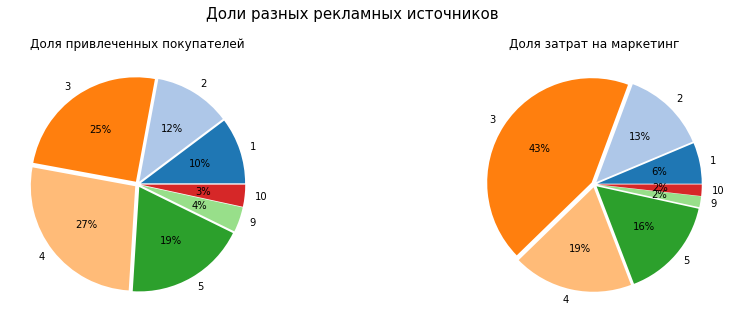

In [55]:
num=0
fig, ax = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle('Доли разных рекламных источников' + '\n', fontsize = 15)
titles = ['Доля привлеченных покупателей','Доля затрат на маркетинг']
costs_per_user['explode'] = 0.03
#Словарь для цветов графика
cdict = dict(zip(np.unique(costs_per_user.index), plt.cm.tab20.colors))

for column in ['users_per_source', 'costs']:
    ax[num].pie(costs_per_user[column], labels = costs_per_user.index
                ,autopct='%.0f%%' 
                ,explode = costs_per_user['explode'] 
               ,colors=[cdict[v] for v in costs_per_user.index])
    ax[num].set_title(titles[num])
    
    plt.subplots_adjust(top=0.85)
    num+=1

Доля рекламного источника 3 в общих затратах на маркетинг составляет 43%, при этом доля привлеченных покупателей всего 25%. Стоимость привлечения одного покупателя из этого источника максимальна. При этом источники 4 и 5 имеют почти такую же долю привлеченных покупателей (27%) при затратах более, чем в два раза ниже. Для остальных источников доля покупателей соответствует доле затрат.

#### Вывод
Расходы на рекламный источник 3 не соответствуют его эффективности. Более перспективным источником является 4, который приносит то же количество покупателей, но для которого цена привлечения клиента более, чем в два раза ниже. Перераспределение маркетингового бюджета между рекламными источниками может сильно снизить расходы при сохранении выручки

***На сколько окупились расходы? (ROI)***

Рассчитаем ROI для вложений в маркетинг (ROMI) по следующей формуле: 


$ ROMI \;рекламной\;кампании = \frac{(валовая\;прибыль - затраты)}{затраты} $


Окупаемость в таком случае будет в точке 0. Отрицательные значения будут соответствовать убыткам, когда затраты выше прибыли.
Перепишем формулу в следущем виде и далее рассчитаем:

$ ROMI\;рекламной\;кампании = \frac{(валовая\;прибыль)}{затраты} -1 $

In [56]:
# Расходы по месяцам
monthly_costs = costs.groupby('month')['costs'].sum()

In [57]:
report = pd.merge(cohorts_orders, monthly_costs, left_on = 'first_order_month', right_on = 'month')

#затраты на привлечение одного пользователя
report['cac'] = report['costs'] / report['n_buyers']

#отношение валовой прибыли c одного пользователя к затратам на привлечение одного пользователя
report['romi'] = (report['gp_per_buyer']) / report['cac']
report.head()

,first_order_month,cohort_age,gp,n_buyers,gp_per_buyer,costs,cac,romi
0,2017-06-01,0,9557.49,2023,4.724414,18015.0,8.905091,0.530530
1,2017-06-01,1,981.82,2023,0.485329,18015.0,8.905091,0.054500
2,2017-06-01,2,885.34,2023,0.437637,18015.0,8.905091,0.049145
3,2017-06-01,3,1931.30,2023,0.954671,18015.0,8.905091,0.107205
4,2017-06-01,4,2068.58,2023,1.022531,18015.0,8.905091,0.114825


In [58]:
#Рассчитаем ROMI и ROI
#Составим таблицу накопительного значения romi по времени жизни, окупаемость будет при значении 1
romi_1 = report.\
            pivot_table(
                index='first_order_month', 
                columns='cohort_age', 
                values='romi').\
            cumsum(axis=1).\
            round(2)

#теперь вычтем 1, чтобы получить 0 при равенстве затрат и доходов
romi_0 = romi_1 - 1

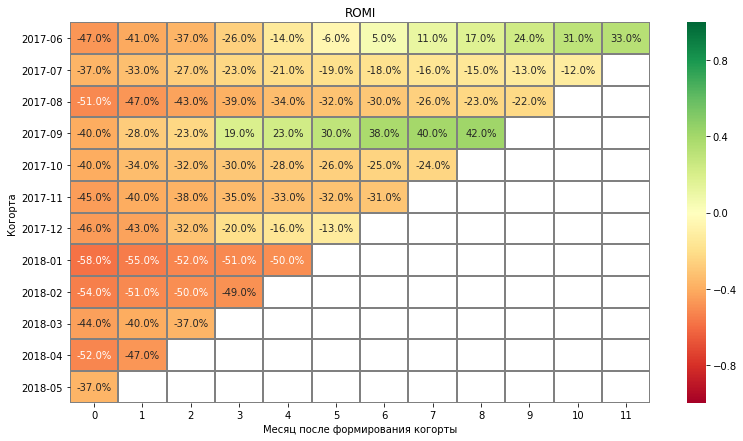

In [59]:
plt.figure(figsize=(13, 7))
plt.title('ROMI')
ax = sns.heatmap(romi_0, 
            annot=True, 
            fmt='.1%', 
            linewidths=1, 
            linecolor='gray', 
            vmax = 1,
            vmin = -1,
            cmap="RdYlGn",
            yticklabels = romi_0.index.strftime('%Y-%m')
                )
plt.ylabel('Когорта')
plt.xlabel('Месяц после формирования когорты')
plt.show()

In [60]:
#Данные за 6 месяцев жизни когорт
romi_0.loc[:,5]

first_order_month
2017-06-01   -0.06
2017-07-01   -0.19
2017-08-01   -0.32
2017-09-01    0.30
2017-10-01   -0.26
2017-11-01   -0.32
2017-12-01   -0.13
2018-01-01     NaN
2018-02-01     NaN
2018-03-01     NaN
2018-04-01     NaN
2018-05-01     NaN
Name: 5, dtype: float64

In [61]:
print('Средний ROMI за 6 месяцев {:.1%}'.format(romi_0.loc[:,5].mean()))

Средний ROMI за 6 месяцев -14.0%


#### Вывод

Маркетинговые расходы окупились только для двух когорт на 7 и 4 месяц после первой покупки соответственно. Остальные когорты были убыточны. Максимальная окупаемость составила 42% за 9 месяцев

Посчитаем ROI отдельно для разных рекламных источников

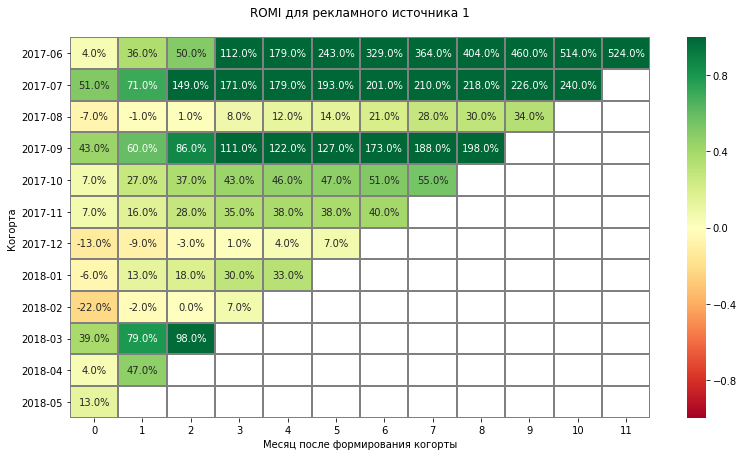

Средний ROMI за 6 месяцев 95.6%


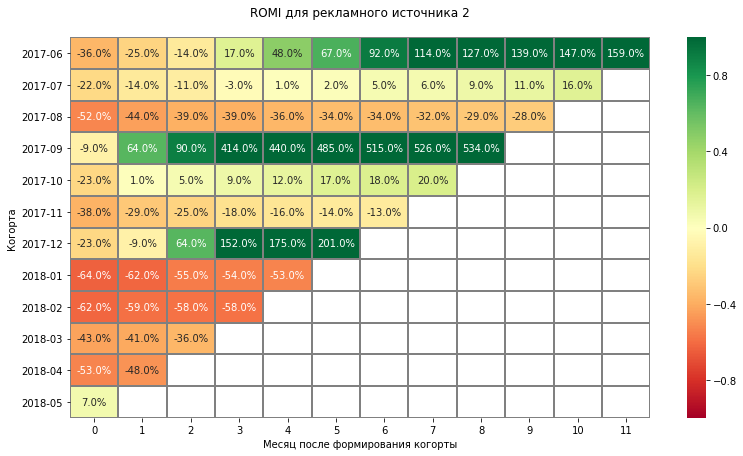

Средний ROMI за 6 месяцев 103.4%


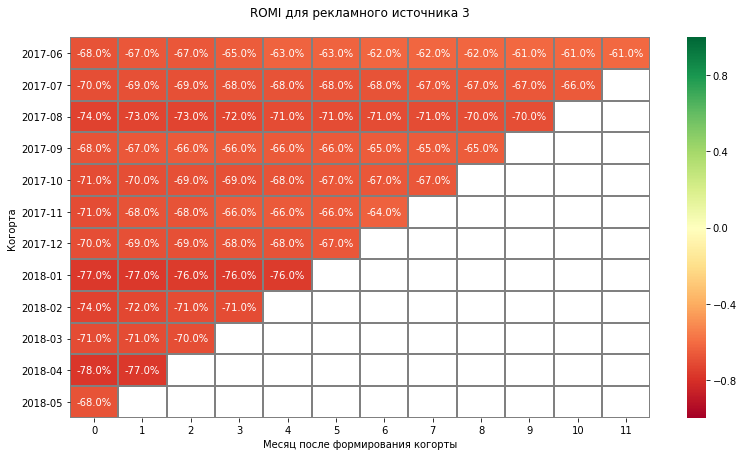

Средний ROMI за 6 месяцев -66.9%


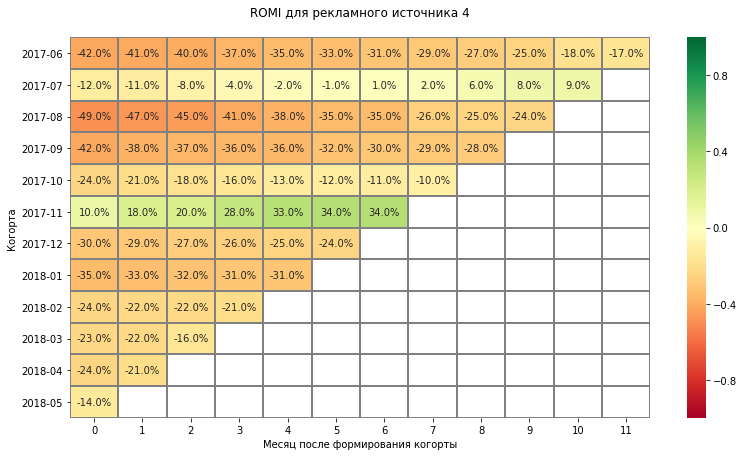

Средний ROMI за 6 месяцев -14.7%


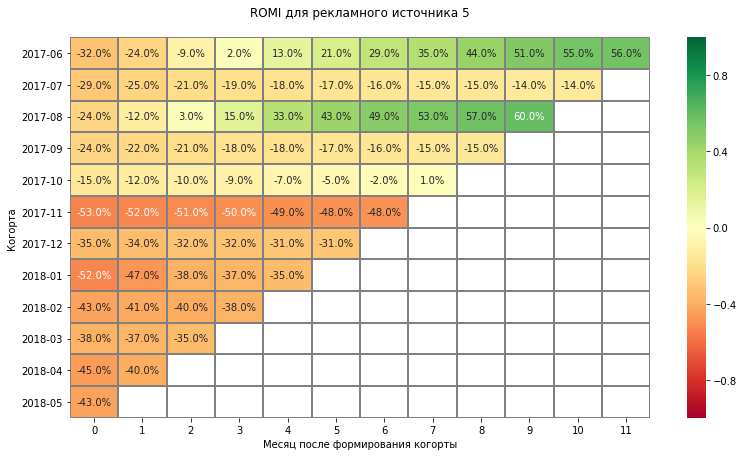

Средний ROMI за 6 месяцев -7.7%


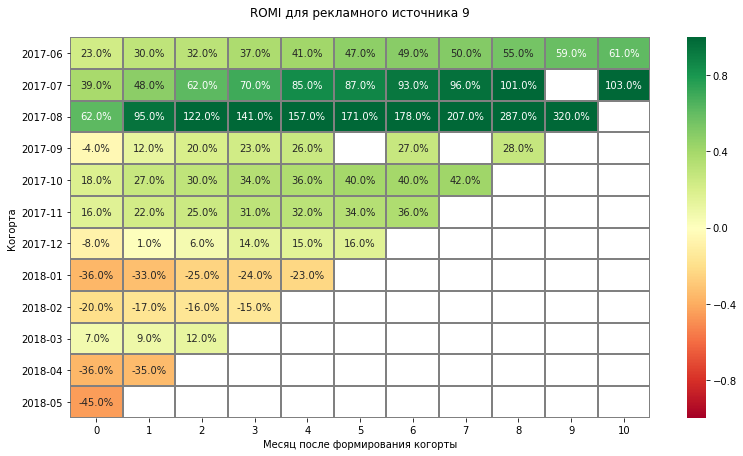

Средний ROMI за 6 месяцев 65.8%


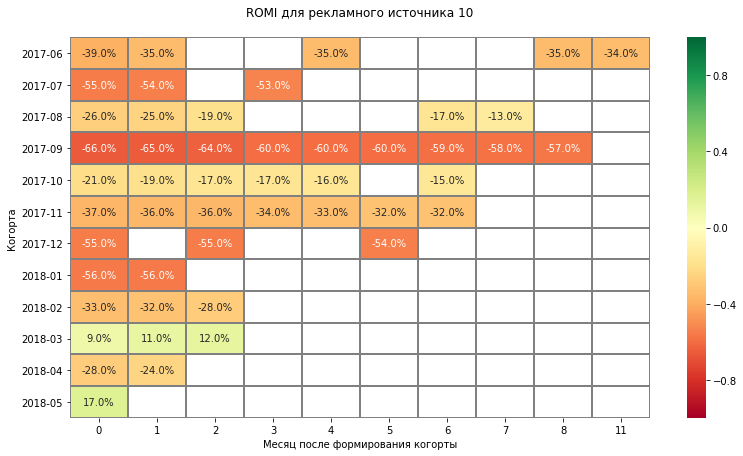

Средний ROMI за 6 месяцев -48.7%


In [62]:
for source in costs['source_id'].unique():
    monthly_costs = costs.\
                    query('source_id == @source').\
                    groupby('month')['costs'].\
                    sum()
   
    buyers_cohorts = orders_log.\
                        query('source_id == @source').\
                        groupby('first_order_month').\
                        agg(n_buyers = pd.NamedAgg(column = 'uid', aggfunc = 'nunique'))
    
    cohorts_orders = orders_log.\
                query('source_id == @source').\
                groupby(['first_order_month','cohort_age']).\
                agg({'revenue': 'sum'}).\
                reset_index().\
                merge(buyers_cohorts, on = 'first_order_month').\
                assign(gp_per_buyer = lambda x: x['revenue'] / x['n_buyers'])
             
    report = pd.merge(cohorts_orders, monthly_costs, left_on = 'first_order_month', right_on = 'month')
    report['cac'] = report['costs'] / report['n_buyers']
    report['romi'] = (report['gp_per_buyer']) / report['cac']
  
    romi_1 = report.pivot_table(
        index='first_order_month', 
        columns='cohort_age', 
        values='romi').cumsum(axis=1).round(2)
    romi_0 = romi_1 - 1
    
    plt.figure(figsize=(13, 7))
    plt.title('ROMI для рекламного источника ' + str(source)+ '\n')
    ax = sns.heatmap(romi_0, 
            annot=True, 
            fmt='.1%', 
            linewidths=1, 
            linecolor='gray', 
            vmax = 1,
            vmin = -1,
            cmap="RdYlGn",
            yticklabels = romi_0.index.strftime('%Y-%m')
                )
    plt.ylabel('Когорта')
    plt.xlabel('Месяц после формирования когорты')
    plt.show()
    print('Средний ROMI за 6 месяцев {:.1%}'.format(romi_0.loc[:,5].mean()))

#### Вывод
Рекламные источники приносят разную прибыль. 
* Расходы для источника 1 окупаются не позже 4 месяца
* Расходы на источник 2 окупились для 5 когорт за 1-5 месяцев, а после августа 2018 года показатели резко упали, и расходы перестали окупаться. В мае 2018 источник окупился за один месяц
* Источник 3 не окупился ни для одной когорты за все время наблюдений. Убыточность при этом достигает 70%
* Источник 4 за 5 месяцев окупился только для одной когорты. Возмжно это связано с какой-то рекламной кампанией
* Источник 5 окупился для двух когорт за 4 месяца, а начиная с сентября 2018 года начал показывать все худшие результаты
* Источник 9 окупился для большинства когорт
* Источник 10 окупился для двух когорт после марта 2018. До этого времени убыточными были все когорты

## Выводы

* Среднее количество уникальных пользователей в день (DAU) = 907

    Среднее количество уникальных пользователей в неделю (WAU) = 5716
    
    Среднее количество уникальных пользователей в месяц (MAU) = 23228

    Наблюдается сезонное снижение числа пользователей летом
    
    
* В среднем пользователь совершает одну сессию в день длительностью 60 сек, что скорее всего соответствует автоматическому завершению сесии при отсутствии действий со стороны пользователя, и совершает первую покупку в первую же сессию. Длительность сессий с использованием компьютера в среднем в два раза длиннее, чем со смартфонов и планшетов


* Количество пользователей, совершающих покупки с мобильных устройств примерно в 5 раз ниже, чем с комьютера. Средний чек также ниже(3.9 тыс. руб и 4.7 тыс руб соответственно)


* Доля клиентов, возвращающихся к использованию сервиса на второй месяц после первого визита в среднем составляет 6.5%, через 6 месяцев - 4%, и эти значения резко упали после декабря 2017 года. В каждой следующей когорте скорость оттока посетителей возрастает. Пользователи чаще возвращаются, если заходят с комьютера (4.3% в среднем за 6 месяцев), чем со смартформа или планшета (3.4% в среднем за 6 месяцев). Возможно пользоватся сервисом в мобильной версии менее удобно 


* Среднее значение количества заказов на пользователя за 6 месяцев составляет 1.43, при этом выручка (LTV) составляет 8 тыс. руб при среднем чеке 5 тыс. руб. Однако это значение LTV завышено из-за одной когорты с аномальным поведением. Без ее учета LTV за 6 месяцев составляет 7.25 тыс. руб


* Средняя стоимость привлечения одного покупателя (САС) составляет 7.62 тыс. руб



* Суммарные расходы на маркетинг превышают выручку на 77 тыс.руб. Средний ROMI за 6 месяцев составил -48.7%


* Расходы на маркетинг распределены по рекламным источников неравномерно. Расходы на источник 3 составляют 43% от общих, при этом доля привлеченных покупателей всего 25%, и их привлечение убыточно: ROMI за 6 месяцев в среднем составляет -67%. Расходы на этот источник необходимо значительно сокращать или полностью от него отказаться. Возможно следует сузить для него целевую аудиторию


* Для всех рекламных источников кроме 10 окупаемоть снижается после декабря 2017 года, необходимо более тщательно проанализировать, что изменилось в это время


* Источниками с наилучшей окупаемостью являются:

    1 - Средний ROMI за 6 месяцев 95.6%, 10% привлеченных клиентов, CAC = 5.57
    
    2 - Средний ROMI за 6 месяцев 103.4%, 12% привлеченных клиентов, CAC = 9.9
    
    9 - Средний ROMI за 6 месяцев 65.8%, 4% привлеченных клиентов, CAC = 3.9
    

* Следует перераспределить рекламные расходы на источники, приносящие максимальную прибыль


* Следует исследовать, почему пользователи значительно меньше используют мобильную версию сервиса, и исправить ее, чтобы сделать более удобной для покупателей
